In [15]:
#Importing libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [16]:
#Getting filenames for images for calibration
images=glob.glob('camera_cal/calibration*.jpg')

imgpoints=[]
objpoints=[]

#Actual corner points in the chessboard
objp=np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

i=0
for fname in images:
    #Reading each chessboard image
    img=mpimg.imread(fname)
    
    #Converting to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #Find the corners of the chessboard
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #Draw the chessboard corners on the images to verify whether the corners are drawn or not and save them
#         out=cv2.drawChessboardCorners(img,(9,6),corners,ret)
#         cv2.imwrite('output_images/'+fname.split('\\')[-1], out)
#         i+=1

#Calibrating the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [35]:
#Undistorting images
def undistorted_img(img,mtx,dist):
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    return dst

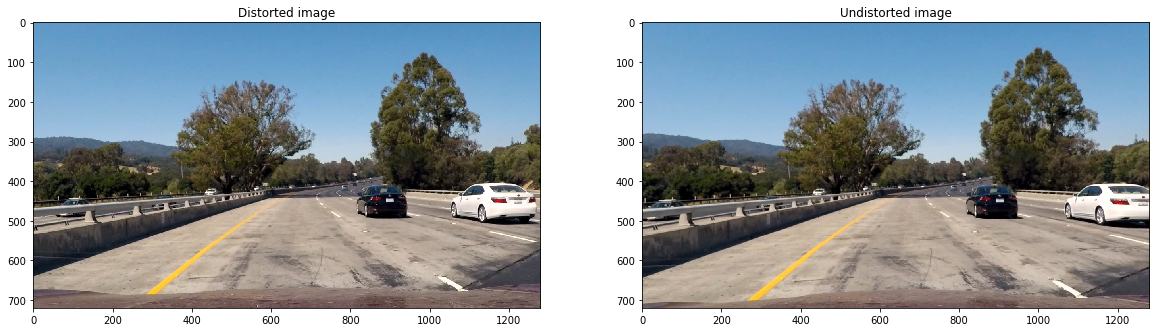

In [36]:
#Undistortion check on chess board image
image_path = 'test_images/test1.jpg'
image_test = mpimg.imread(image_path)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_test)
ax1.set_title('Distorted image')
undist=undistorted_img(image_test,mtx,dist)
ax2.imshow(undist)
ax2.set_title('Undistorted image')

#Saving undistorted image
# cv2.imwrite('output_images/test1_undist.jpg', undist)

In [74]:
#Functions for Sobel orientation, Sobel magnitude, Sobel Direction and Color thresholding
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sob_val=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if orient=='y':
        sob_val=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)        
    abs_sob=np.absolute(sob_val)
    norm_sobel=np.uint8(abs_sob*255/np.max(abs_sob))
    grad_binary=np.zeros_like(norm_sobel)
    grad_binary[(norm_sobel>=thresh[0])&(norm_sobel<=thresh[1])]=1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sob_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sob_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel) 
    abs_sob=np.sqrt((sob_x**2)+(sob_y**2))
    norm_sob=np.uint8(abs_sob*255/np.max(abs_sob))
    mag_binary=np.zeros_like(norm_sob)
    mag_binary[(norm_sob>=mag_thresh[0]) & (norm_sob<=mag_thresh[1])]=1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobel_x=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobelx_abs=np.absolute(sobel_x)
    sobely_abs=np.absolute(sobel_y)
    gradient_dir=np.arctan2(sobely_abs,sobelx_abs)
    dir_binary=np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir>=thresh[0])&(gradient_dir<=thresh[1])]=1
    return dir_binary

def color_threshold(image, thresh):
    #Convert image to HLS color channel
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    
    #Extract the S channel image
    s_channel = hls[:,:,2]

    #Applying threshold                
    sxbinary = np.zeros_like(s_channel)
    sxbinary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return sxbinary

True

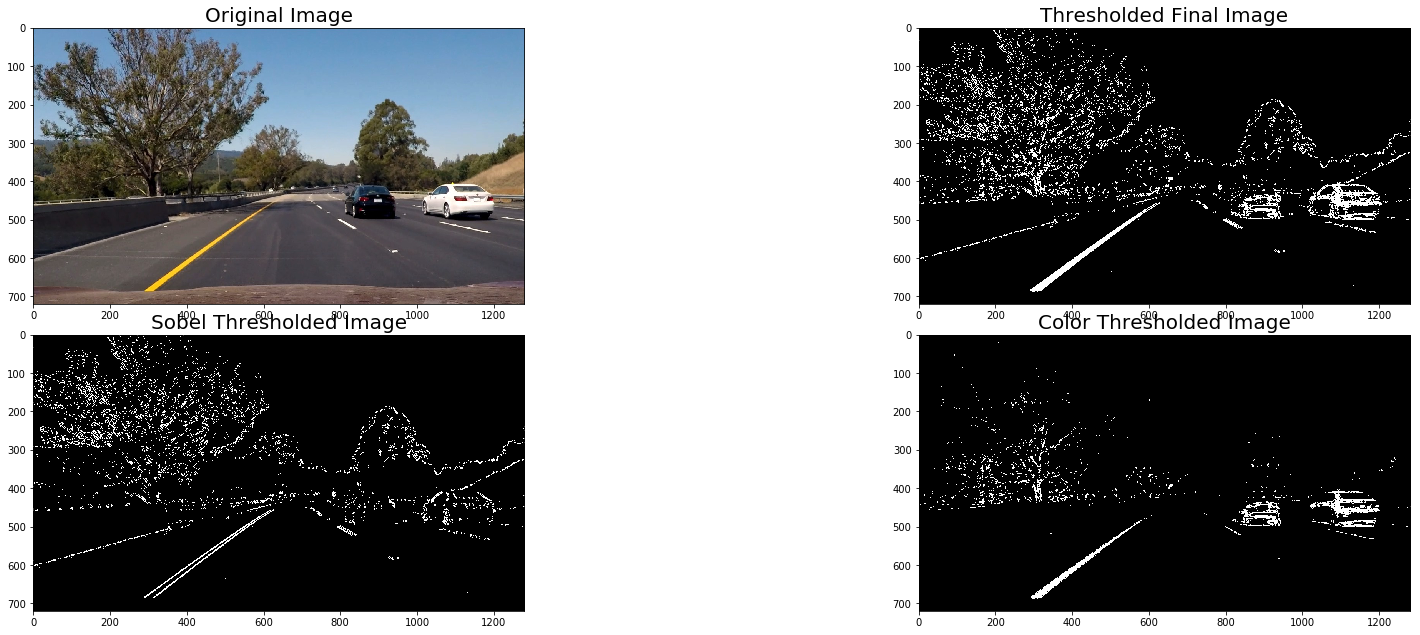

In [123]:
#Printing the thresholded output image
# Read in an image
image = mpimg.imread('test_images/test6.jpg')

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 180))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 180))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 200))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7 ,1.3))

sobel_combined = np.zeros_like(dir_binary)
sobel_combined[((gradx ==1) & (grady ==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 

sxbinary = color_threshold(image, thresh=(160,255))

# Combine the Sobel and color binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(sobel_combined == 1) | (sxbinary == 1)] = 1

# Plot the result
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Final Image', fontsize=20)
ax3.imshow(sobel_combined, cmap='gray')
ax3.set_title('Sobel Thresholded Image', fontsize=20)
ax4.imshow(sxbinary, cmap='gray')
ax4.set_title('Color Thresholded Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# #Saving images
# cv2.imwrite('output_images/final_thresh.jpg', combined_binary*255)
# cv2.imwrite('output_images/sobel_thresh.jpg', sobel_combined*255)
# cv2.imwrite('output_images/color_thresh.jpg', sxbinary*255)

In [ ]:
#Pipeline
def adv_lane_find(image,mtx,dist):
    #Undistort the image
    undist=undistorted_img(image,mtx,dist)
    
    #Kernel size for the Sobel Filter
    ksize = 7

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 180))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 180))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7 ,1.3))

    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx ==1) & (grady ==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 

    sxbinary = color_threshold(image, thresh=(160,255))

    # Combine the Sobel and color binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sobel_combined == 1) | (sxbinary == 1)] = 1